In [1]:
import openai
import re
import httpx
from dotenv import load_dotenv
import os

_ = load_dotenv()
from openai import OpenAI

In [2]:
client = OpenAI()

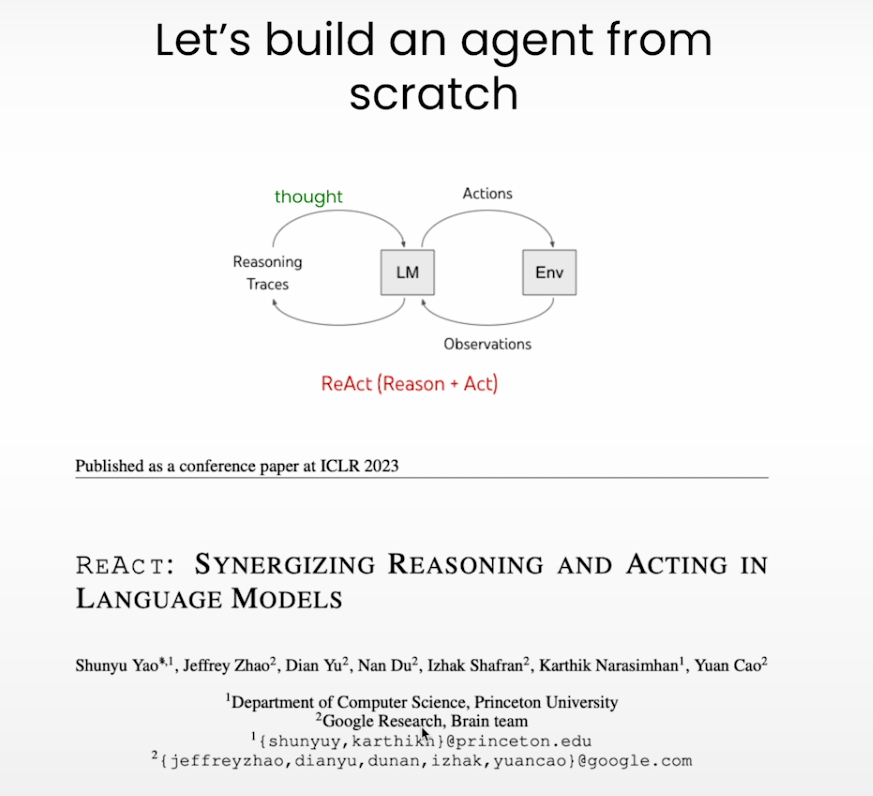

In [3]:
# based on https://til.simonwillison.net/llms/python-react-pattern

In [4]:
response = client.chat.completions.create(
    model='gpt-3.5-turbo',
    messages=[{"role":"user","content": "hello world"}]
)
print (response.choices[0].message.content)

Hello! How can I assist you today?


In [5]:
class Agent:
    def __init__(self, system=""):
        self.system = system
        self.messages = []
        if self.system:
            self.messages.append({"role":"system","content":system})
    
    def __call__ (self, message):
        self.messages.append({"role":"user", "content":message})
        # print (self.messages)
        result = self.execute()
        self.messages.append({'role':"assistant", "content":result})
        return result
    
    def execute(self):
        response = client.chat.completions.create(
          model='gpt-3.5-turbo',
          temperature=0.0,
          messages = self.messages
        )
        return response.choices[0].message.content

In [6]:
prompt = """ You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

average_dog_weight:
e.g. average_dog_weight: Collie
returns average weight of a dog when given the breed

Example session:

Question: How much does a Bulldog weigh?
Thought: I should look the dogs weight using average_dog_weight
Action: average_dog_weight: Bulldog
PAUSE

You will be called again with this:

Observation: A Bulldog weights 51 lbs

You then output:

Answer: A bulldog weights 51 lbs
""".strip()

In [7]:
def calculate(what):
    return eval(what)

def average_dog_weight(name):
    if name in "Scottish Terrier": 
        return("Scottish Terriers average 20 lbs")
    elif name in "Border Collie":
        return("a Border Collies average weight is 37 lbs")
    elif name in "Toy Poodle":
        return("a toy poodles average weight is 7 lbs")
    else:
        return("An average dog weights 50 lbs")

known_actions = {
    "calculate":calculate,
    "average_dog_weight":average_dog_weight
}  

In [8]:
abot = Agent(prompt)
result = abot("how much a Scottish Terrier weigh?")
print (result)


Thought: I should look up the average weight of a Scottish Terrier using the average_dog_weight action.
Action: average_dog_weight: Scottish Terrier
PAUSE


In [9]:
result = average_dog_weight("Scottish Terrier")
print (result)

Scottish Terriers average 20 lbs


In [10]:
next_prompt = 'Observation: {}'.format(result)
result = abot(next_prompt)
print (result)

Answer: A Scottish Terrier weighs 20 lbs


In [11]:
abot.messages

[{'role': 'system',
  'content': 'You run in a loop of Thought, Action, PAUSE, Observation.\nAt the end of the loop you output an Answer\nUse Thought to describe your thoughts about the question you have been asked.\nUse Action to run one of the actions available to you - then return PAUSE.\nObservation will be the result of running those actions.\n\nYour available actions are:\n\ncalculate:\ne.g. calculate: 4 * 7 / 3\nRuns a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary\n\naverage_dog_weight:\ne.g. average_dog_weight: Collie\nreturns average weight of a dog when given the breed\n\nExample session:\n\nQuestion: How much does a Bulldog weigh?\nThought: I should look the dogs weight using average_dog_weight\nAction: average_dog_weight: Bulldog\nPAUSE\n\nYou will be called again with this:\n\nObservation: A Bulldog weights 51 lbs\n\nYou then output:\n\nAnswer: A bulldog weights 51 lbs'},
 {'role': 'user', 'content': 'how much a Scott

In [12]:
abot = Agent(prompt)
question = """ I have two dogs, a border collie and a scottish terrier.\
    what is the combined weight?"""
result = abot(question)
print (result)

Thought: I can find the average weight of a Border Collie and a Scottish Terrier using the average_dog_weight action and then calculate the combined weight.

Action: average_dog_weight: Border Collie
PAUSE


In [13]:
next_prompt = 'Observation: {}'.format(average_dog_weight("Border Collie"))
print (next_prompt)

Observation: a Border Collies average weight is 37 lbs


In [14]:
abot (next_prompt)

'Action: average_dog_weight: Scottish Terrier\nPAUSE'

In [15]:
next_prompt = 'Observation: {}'.format(average_dog_weight("Scottish Terrier"))
print (next_prompt)


Observation: Scottish Terriers average 20 lbs


In [16]:
result = abot (next_prompt)

In [17]:
print (result)

Action: calculate: 37 + 20
PAUSE


In [18]:
next_prompt = 'Observation: {}'.format(calculate("37+20"))
abot(next_prompt)

'Answer: The combined weight of a Border Collie and a Scottish Terrier is 57 lbs.'

In [19]:
action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to selection action

<>:1: SyntaxWarning: invalid escape sequence '\w'
<>:1: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_2092/2389047760.py:1: SyntaxWarning: invalid escape sequence '\w'
  action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to selection action


In [20]:
def query(question):
    i = 0
    abot = Agent(prompt)
    next_prompt = question
    while i < 5:
        result = abot(next_prompt)
        actions = [action_re.match(a) for a in result.split("\n") if action_re.match(a)]
        if actions:
            # print (f"actions[0]:{actions[0]}")
            # print (f"actions[0].groups:{actions[0].groups()}")
            action, action_input = actions[0].groups()
            if action not in known_actions:
                raise Exception("Unknown action: {}: {}".format(action, action_input))
            else:
                print ("---running {}: {}".format (action, action_input))
                observation = known_actions[action](action_input)
                print ("Observation: {}".format(observation))
                next_prompt = "Observation: {}".format(observation)
        else:
            return "No more actions to take"
        
question = """I have 2 dogs, a border collie and a scottish terrier. \
What is their combined weight"""
query(question)
    

---running average_dog_weight: Border Collie
Observation: a Border Collies average weight is 37 lbs
---running average_dog_weight: Scottish Terrier
Observation: Scottish Terriers average 20 lbs
---running calculate: 37 + 20
Observation: 57


'No more actions to take'